In [211]:
import os
import pandas as pd
import numpy as np
import re 
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

def load_data(dataset, DATA_DIR='./data/'):
    read_args = {
        'node_information':{
            'names': ['id', 'publication_date', 'title', 'authors', 'journal', 'abstract'],
            'index_col': 'id'
        },
        'train': {
            'names': ['source_id', 'target_id','category'],
            'sep': ' ',
        },
        'test':{
            'names':['source_id', 'target_id'],
            'sep': ' ',
        }
    }
    filenames = {
        'node_information': 'node_information.csv',
        'train': 'training_set.txt',
        'test': 'testing_set.txt'
    }
    if dataset in read_args:
        file_path = os.path.join(DATA_DIR, filenames[dataset])
        return pd.read_csv(file_path, header=None, **read_args[dataset])

In [ ]:
def box_plot(dataset, feature):
    feature = 'source_publication_date'
    positive = dataset.category == 1
    negative = dataset.category == 0
    positive = dataset[positive][feature]
    negative = dataset[negative][feature]


    fig, axarr = plt.subplots(1,2, figsize=(10,5))
    axarr[0].boxplot(positive)
    axarr[1].boxplot(negative)
    axarr[0].set_title(f'{feature} when connected')
    axarr[1].set_title(f'{feature} when not connected')
    

In [ ]:
def merge_node_information(dataset, node_information):
    for column in node_information.columns:
        for origin in ['source', 'target']:
            serie = node_information[column].rename(f'{origin}_{column}').to_frame()
            dataset = dataset.merge(serie, left_on=f'{origin}_id', right_index=True)
    return dataset

In [170]:
def box_plot_feature(series, positive, negative, title=None):
    positive = series[positive]
    negative = series[negative]

    fig, axarr = plt.subplots(1,2, figsize=(10,5))
    axarr[0].boxplot(positive)
    axarr[1].boxplot(negative)
    if title:
        axarr[0].set_title(f'{title} when connected')
        axarr[1].set_title(f'{title} when not connected')
    

In [2]:
node_information = load_data('node_information', data_dir='../data')

In [4]:
train = load_data('train', data_dir='../data')

In [91]:
x = merge_node_information(train, node_information)

## Publication date difference

In [171]:
publication_date_diff = x.source_publication_date - x.target_publication_date

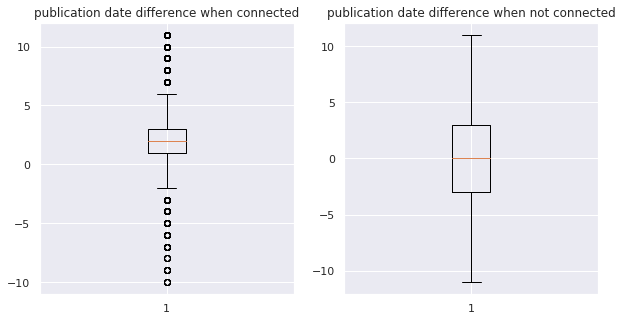

In [172]:
box_plot_feature(publication_date_diff, positive, negative, 'publication date difference')

In [173]:
(x[positive].source_publication_date < x[positive].target_publication_date).value_counts()

False    333006
True       2124
dtype: int64

In [174]:
2124/333006

0.0063782634547125275

We can notice that most of the articles quote articles that were written in the past, which is quite logical, the remaining is probably particular cases (only 0.006%), this features will help us a lot to splitt connected and non connected when the source publication date is older than the destination one

## Title overlaping

In [188]:
english_stopwords = set(stopwords.words('english'))
stem = PorterStemmer()

def tokenize(string):
    words = []
    for word in string.split():
        if word not in english_stopwords:
            words.append(stem.stem(word))
    return words

string = 'an infinite number of potentials surrounding 2d black hole'
tokenize(string)

def overlap(string1, string2):
    return len(set(tokenize(string1)).intersection(set(tokenize(string2))))

In [189]:
title_overlap = x.apply(lambda x: overlap(x.source_title, x.target_title), axis='columns')

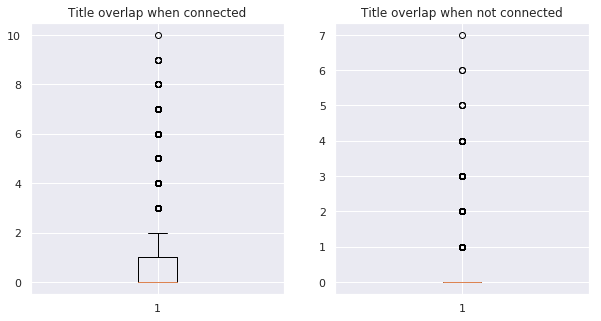

In [190]:
box_plot_feature(title_overlap, positive, negative, 'Title overlap')

In [191]:
import time
st = time.time()
x.apply(lambda x: overlap(x.source_title, x.target_title), axis='columns')
print(time.time()-st)

193.36956787109375


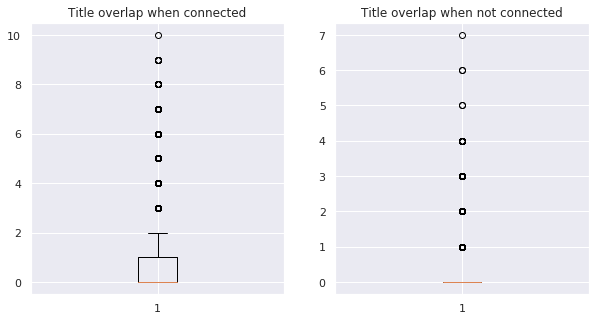

In [178]:
box_plot_feature(title_overlap, positive, negative, 'Title overlap')

In [161]:
(title_overlap[negative] > 0).value_counts()

False    255652
True      24730
dtype: int64

In [179]:
24730/255652

0.09673305900208096

In [180]:
(title_overlap[positive] > 0).value_counts()

False    194318
True     140812
dtype: int64

In [181]:
140812/194318

0.7246472277400962

As we can see title overlapping can allow us to detect whether articles are connected, 72% of connected articles have an overlapping in the title agains 9.6% for not connected

## Common authors

In [182]:
x.target_authors

0         Won T. Kim, Julian Lee, , Young Jai Park
510736    Won T. Kim, Julian Lee, , Young Jai Park
451434    Won T. Kim, Julian Lee, , Young Jai Park
168455    Won T. Kim, Julian Lee, , Young Jai Park
170930    Won T. Kim, Julian Lee, , Young Jai Park
21430     Won T. Kim, Julian Lee, , Young Jai Park
426916    Won T. Kim, Julian Lee, , Young Jai Park
201084    Won T. Kim, Julian Lee, , Young Jai Park
167792    Won T. Kim, Julian Lee, , Young Jai Park
192101    Won T. Kim, Julian Lee, , Young Jai Park
126225    Won T. Kim, Julian Lee, , Young Jai Park
514327    Won T. Kim, Julian Lee, , Young Jai Park
222625    Won T. Kim, Julian Lee, , Young Jai Park
486060    Won T. Kim, Julian Lee, , Young Jai Park
484078    Won T. Kim, Julian Lee, , Young Jai Park
411789    Won T. Kim, Julian Lee, , Young Jai Park
28303     Won T. Kim, Julian Lee, , Young Jai Park
513109    Won T. Kim, Julian Lee, , Young Jai Park
448365    Won T. Kim, Julian Lee, , Young Jai Park
561330    Won T. Kim, Julian Le

In [209]:
def extract_authors(authors):
    stopwords = ['alex', 't', 'latex', 'pages', 'jr', 's']
    if isinstance(authors, str):
        
        # Remove string between parenthesis
        string = re.sub(r'\([^\)]+[\)$]','',authors)
        # Remove bad parenthesis
        string = re.sub(r'\([^\)]*$','', string)
        # Remove multiple spaces
        string = re.sub(r'\s', '', string)
        # Extract authors and sanityze strings
        
        authors = []
        for author in string.split(','):
            author = author.lower()
            author = re.sub(r'[\W\d]','', author).lower()
            if len(author) >= 2 and not author in stopwords:
                authors.append(author)
        return authors

def common_authors(authors1, authors2):
    if isinstance(authors1, str) and isinstance(authors2, str):
        return len(set(extract_authors(authors1)).intersection(set(extract_authors(authors2))))
    

In [212]:
common_authors = x.apply(lambda x: common_authors(x.source_authors, x.target_authors), axis='columns')

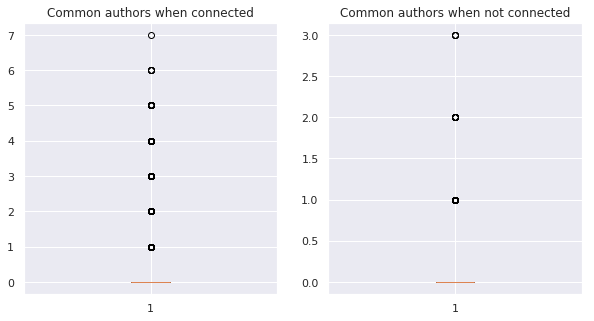

In [217]:
box_plot_feature(common_authors.dropna(), positive, negative, 'Common authors')

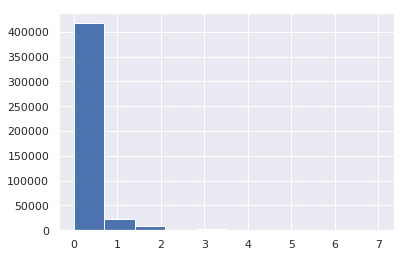

In [223]:
common_authors.hist()

In [225]:
(common_authors[positive] > 0).value_counts()

False    299473
True      35657
dtype: int64

###### Paper with common authors

In [229]:
35657/299473

0.11906582563369653

In [226]:
(common_authors[negative] > 0).value_counts()

False    280206
True        176
dtype: int64

In [228]:
176/280206

0.0006281093195720292

Common authors can be a good features for our problem as 12% of connected articles have more than 1 common authors against 0.06% for articles not connected 